# GMM and EM
Gaussian Mixture Models and Expectation Maximization  

Here we show canned and homgrown implementations.

## Using a library call
Follow tutorial in [mastery](https://machinelearningmastery.com/expectation-maximization-em-algorithm/)

Use [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) class GaussianMixture.

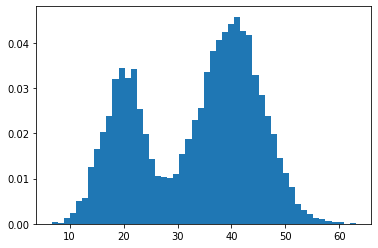

In [1]:
# Straight from the Mastery site.
# Construct a bimodal from two Gaussian processes.
from numpy import hstack
from numpy.random import normal
from matplotlib import pyplot
# normal ( mean, standard deviation, count )
def plot(X1,X2):
    X = hstack( (X1, X2) )  # horizontal stack i.e. concat
    pyplot.hist(X, bins=50, density=True)
    pyplot.show()
X1 = normal(loc=20, scale=4, size=3000) 
X2 = normal(loc=40, scale=6, size=6000)
plot(X1,X2)

In [2]:
def show_gmm(model):
    print(model)
    for i in range(model.n_components):
        print('Gaussian',i,'mean=',model.means_[i],
            'wgt=',model.weights_[i], 
            'Cov=',model.covariances_[i])

In [3]:
# Straight from the Mastery site.
# Use EM to reverse engineer the model i.e. fit a GMM to the data.
from sklearn.mixture import GaussianMixture
X = hstack( (X1, X2) ) 
X = X.reshape((len(X), 1))
# By default, covariance=‘full’: each component has its own general covariance matrix.
# Use 'spherical' (one variance per mean) since our data has only one feature.
# By default, init_params='kmeans'. Works much better than 'random'!
model = GaussianMixture(n_components=2, verbose=1, covariance_type='spherical')
model.fit(X)
show_gmm(model)

Initialization 0
Initialization converged: True
GaussianMixture(covariance_type='spherical', n_components=2, verbose=1)
Gaussian 0 mean= [20.05309374] wgt= 0.34004644852388455 Cov= 16.718874625114612
Gaussian 1 mean= [40.22980955] wgt= 0.6599535514761126 Cov= 33.756151766542985


In [4]:
yhat = model.predict(X)
print('Predicted class of a point on the left:',yhat[100])
print('Predicted class of a point on the right:',yhat[-100])

Predicted class of a point on the left: 0
Predicted class of a point on the right: 1


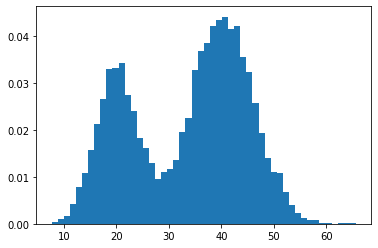

In [5]:
mean0=model.means_[0]
mean1=model.means_[1]
G0 = normal(loc=mean0, scale=4, size=3000) 
G1 = normal(loc=mean1, scale=6, size=6000)
if mean0>mean1:
    G0 = normal(loc=mean0, scale=4, size=6000) 
    G1 = normal(loc=mean1, scale=6, size=3000)
plot(G0,G1)

## Homegrown version
Assumption: the observed data was generated by n Gaussian processes.
Easy case: one-dimensional data (avoids matricies & covariance).
Easy case: n=2.

See [YouTube](https://youtu.be/iQoXFmbXRJA) video by Victor Lavrenko.

At each iteration, we have two models to explain the data.
Each model "votes" for each data point by assigning its Gaussian probability.

The weight for the ith data point w[i]   
equals   
prob_of_i_under_model_1 / prob_of_i_under_all_models  
equals  
prob_of_i_under_model_1 / prob_of_i_under_model_1+prob_of_i_under_model_2

Alternately, we can use Bayes rule to calculate posterior probabilities if priors are known.
This code sets both priors to 50% so it doesn't really use Bayes. 
Optionally, this code can update the prior by counting cluster size at each step.
It is not clear that these updates are justified,
and in practice is makes the results much worse. 
We've seen it go on a downhill spiral where stdev and thus prior approach 0.

In [26]:
import scipy.stats as ss
import numpy as np
def likelihood_of_data(mean,stdev,data):
    # Likelihood of each datapoint under the given Gaussian parameters.
    L=np.asarray([ss.norm.pdf(x,loc=mean,scale=stdev) for x in data])
    return L
def conditional_probabilities(like1,like2): 
    # get conditional probability of each model given these likelihoods
    length = len(like1)
    cond1=np.zeros(length)
    cond2=np.zeros(length)
    # TO DO: use vectors instead of for loop 
    for i in range(length):      
        # This formula is same as Bayes rule 
        # if we multiply both likelihoods by prior=50%
        prob_of_data = like1[i]+like2[i]
        cond1[i] = like1[i] / prob_of_data  
        cond2[i] = like2[i] / prob_of_data  
    return cond1,cond2
def mle_mean(weights,data):
    length = len(data)
    weighted = data*weights  # Hadamard vector multiply
    mean=sum(weighted)/sum(weights)
    return mean
def mle_stdev(mean,weights,data):
    # sum of the squares of the weighted deviations from the mean
    dev = data-mean
    wdev = dev*weights
    sse = sum(wdev**2)
    stdev=float(np.sqrt(sse/sum(weights)))
    return stdev
def expectation_maximization(data,num_iter):
    # These initial guesses are arbitrary but based on the overall data.
    mean=np.mean(data)
    stdev=np.std(data)
    mean1 = mean-0.5
    mean2 = mean+0.5
    stdev1 = stdev
    stdev2 = stdev
    print('Initial means: %f +/- %d, %f +/- %d'%(mean1,stdev1,mean2,stdev2))
    for i in range(num_iter):
        # likelihood of each data point under each Gaussian model
        like1 = likelihood_of_data(mean1,stdev1,data)
        like2 = likelihood_of_data(mean2,stdev2,data)
        # conditional prob of each point assuming either Gaussian model
        cond1,cond2 = conditional_probabilities(like1,like2)
        # re-compute MLE given the conditionals
        mean1 = mle_mean(cond1,data)
        mean2 = mle_mean(cond2,data)
        stdev1 = mle_stdev(mean1,cond1,data)
        stdev2 = mle_stdev(mean2,cond2,data)
        print('Intermediate means: %f +/- %d, %f +/- %d'%(mean1,stdev1,mean2,stdev2))
    print()
    print('Final means: %f +/- %d, %f +/- %d'%(mean1,stdev1,mean2,stdev2))
    return mean1,mean2,stdev1,stdev2

In [27]:
X1 = normal(loc=20, scale=4, size=3000) 
X2 = normal(loc=40, scale=6, size=6000)
X = hstack( (X1, X2) ) 
X = np.asarray(X)
mean1,mean2,stdev1,stdev2=expectation_maximization(X,20)

Initial means: 32.853365 +/- 10, 33.853365 +/- 10
Intermediate means: 32.854026 +/- 7, 33.852696 +/- 7
Intermediate means: 32.303825 +/- 8, 34.427703 +/- 7
Intermediate means: 31.135043 +/- 8, 35.787601 +/- 6
Intermediate means: 29.308834 +/- 9, 38.341446 +/- 4
Intermediate means: 27.819773 +/- 9, 40.347093 +/- 3
Intermediate means: 27.084902 +/- 8, 41.274618 +/- 3
Intermediate means: 26.602027 +/- 8, 41.840215 +/- 3
Intermediate means: 25.927297 +/- 7, 42.240890 +/- 3
Intermediate means: 24.927243 +/- 6, 42.445485 +/- 4
Intermediate means: 23.974419 +/- 6, 42.202100 +/- 4
Intermediate means: 23.206768 +/- 5, 41.872863 +/- 4
Intermediate means: 22.559093 +/- 5, 41.593148 +/- 4
Intermediate means: 22.021608 +/- 5, 41.352999 +/- 4
Intermediate means: 21.586262 +/- 4, 41.149522 +/- 4
Intermediate means: 21.244946 +/- 4, 40.981724 +/- 5
Intermediate means: 20.986302 +/- 4, 40.847931 +/- 5
Intermediate means: 20.796235 +/- 4, 40.744899 +/- 5
Intermediate means: 20.660133 +/- 4, 40.668104 +/

## Explanation
Assume every point was generated by process 0 or process 1.
Z is a vector naming the generating process for each point. 
Z is an unknown, a latent variable, that we'll predict.

Assume processes 0 and 1 are Gaussian. 
Each has a mean and stdev.
These are the parameters of the generating model.
These are unknowns that we'll estimate.

Start by guessing the number of processes, and the mean and stdev of each.

EM loops over two steps.  
* E-Step: The word expectation is not helpul. For every point, assign responsibility to each process. For K-means, assign 0 for one and 1 for the other i.e. all-or-nothing. For GMM, assign probabilities that sum to one across all processes.  
* M-Step: Re-estimate the mean and stdev of each process. Use maximum likelihood to choose parameters that maximize the likelihood of this data. When computing the new mean and stdev, weight the sums by the assigned responsibilities. 